# Аналіз логістичних маршрутів за RPM


# Завантаження даних та базове очищення

Завантажуємо Excel-файл з даними. Видаляємо записи, в яких відсутні критично важливі поля для аналізу: тариф, милі, міста відправлення/прибуття, RPM. Приводимо числові поля до відповідного типу.

In [33]:
import pandas as pd

df = pd.read_excel("../Loads 2024.xlsx", sheet_name="DATA")

df = df.dropna(subset=["Rate", "Miles", "From City", "From State", "To City", "To State", "RPM"])
df["Miles"] = pd.to_numeric(df["Miles"], errors="coerce")
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
df["RPM"] = pd.to_numeric(df["RPM"], errors="coerce")

# Вибір топ-5 найвигідніших маршрутів за RPM

Відсортуємо таблицю за показником RPM (дохід за милю) у спадному порядку і візьмемо 5 найкращих маршрутів.

In [34]:
top_profitable = df.sort_values("RPM", ascending=False)
top_5_profitable = top_profitable.head(5)
top_5_profitable[["From City", "From State", "To City", "To State", "Rate", "Miles", "RPM"]]

,From City,From State,To City,To State,Rate,Miles,RPM
2966,STOCKTON,CA,STOCKTON,CA,1200.0,2.0,600.0000
3224,CHICAGO,IL,CHICAGO,IL,200.0,2.0,100.0000
3503,BOLINGBROOK,IL,MOUNTVILLE,PA,1750.0,77.0,22.7273
1365,FONTANA,CA,MIRA LOMA,CA,350.0,16.0,21.8750
1366,FONTANA,CA,MIRA LOMA,CA,350.0,16.0,21.8750


# Побудова стовпчикової діаграми

Візуалізуємо топ-5 найвигідніших маршрутів за RPM, де по осі Y – місто відправлення, по осі X – RPM, кольором позначено місто прибуття.

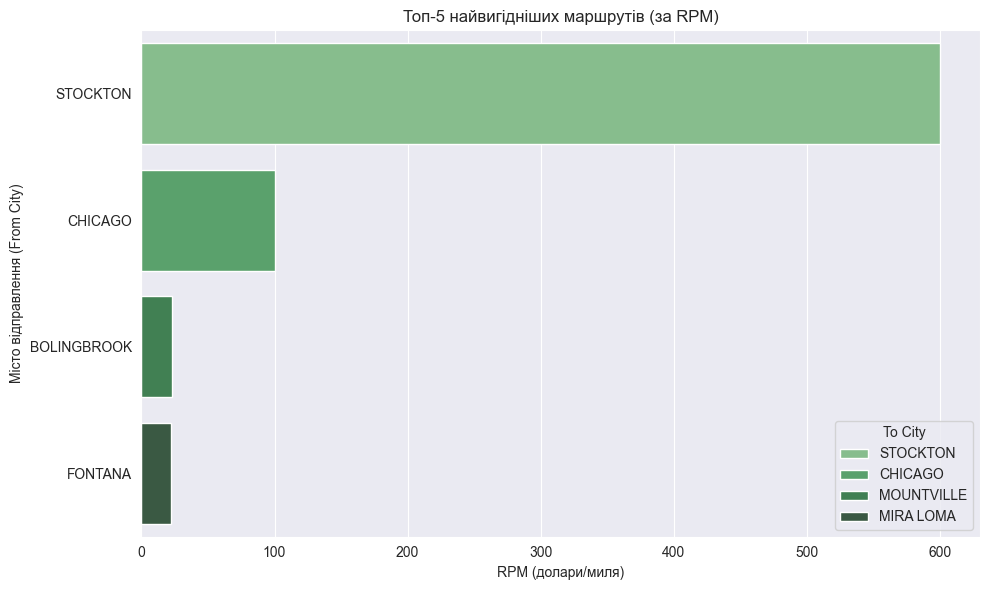

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_profitable,
    y="From City",
    x="RPM",
    hue="To City",
    palette="Greens_d"
)
plt.title("Топ-5 найвигідніших маршрутів (за RPM)")
plt.xlabel("RPM (долари/миля)")
plt.ylabel("Місто відправлення (From City)")
plt.tight_layout()
plt.show()

# Відображення маршрутів на інтерактивній карті

За допомогою бібліотек geopy, openrouteservice та folium відобразимо маршрути на карті США. Для кожного маршруту виведемо шлях, маркери початку та кінця, а також інформацію про відстань, тариф та RPM.

In [36]:
from geopy.geocoders import Nominatim
import openrouteservice
from openrouteservice import convert
import folium
import time
from tqdm import tqdm

ORS_API_KEY = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjRkNDI3MjgwYTJjZDRhYzNhMzVlZjM5ZTY5NmM2N2YyIiwiaCI6Im11cm11cjY0In0="

geolocator = Nominatim(user_agent="logistics-map")
ors_client = openrouteservice.Client(key=ORS_API_KEY)
m_profitable = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in tqdm(top_5_profitable.iterrows(), total=top_5_profitable.shape[0]):
    from_city = row["From City"]
    from_state = row["From State"]
    to_city = row["To City"]
    to_state = row["To State"]
    miles = row["Miles"]
    rate = row["Rate"]
    rpm = row["RPM"]

    try:
        from_loc = geolocator.geocode(f"{from_city}, {from_state}", timeout=10)
        to_loc = geolocator.geocode(f"{to_city}, {to_state}", timeout=10)
        time.sleep(1)

        if from_loc and to_loc:
            from_coords = (from_loc.latitude, from_loc.longitude)
            to_coords = (to_loc.latitude, to_loc.longitude)

            coords = [(from_coords[1], from_coords[0]), (to_coords[1], to_coords[0])]
            route = ors_client.directions(coords)
            decoded = convert.decode_polyline(route['routes'][0]['geometry'])

            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in decoded["coordinates"]],
                tooltip=f"{from_city} → {to_city} | {miles} mi | ${rate} | RPM: {rpm:.2f}",
                color="green"
            ).add_to(m_profitable)

            folium.Marker(location=from_coords, popup=f"{from_city}, {from_state}",
                          icon=folium.Icon(color="green")).add_to(m_profitable)
            folium.Marker(location=to_coords, popup=f"{to_city}, {to_state}",
                          icon=folium.Icon(color="red")).add_to(m_profitable)
        else:
            print(f"Пропущено (немає координат): {from_city} → {to_city}")

    except Exception as e:
        print(f"Помилка маршруту {from_city} → {to_city}: {e}")

m_profitable

100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


# Виявлення маршрутів з RPM рівним нулю

Визначаємо маршрути, у яких RPM дорівнює 0. Виводимо кількість таких маршрутів та таблицю з їх деталями. Ці маршрути не враховуються у подальшому аналізі через відсутність інформації про ефективність.

In [37]:
zero_rpm_routes = df[df["RPM"] == 0]

print(f"Увага: {zero_rpm_routes.shape[0]} маршрутів мають RPM = 0 і не враховуються")
zero_rpm_routes[["From City", "From State", "To City", "To State", "Rate", "Miles", "RPM"]]

Увага: 9 маршрутів мають RPM = 0 і не враховуються


,From City,From State,To City,To State,Rate,Miles,RPM
2288,MORTON,MS,SAINT LOUIS,MO,0.0,531.0,0.0
4611,HODGKINS,IL,JOHNSTOWN,NY,0.0,800.0,0.0
4945,REESEVILLE,WI,MELROSE PARK,IL,0.0,145.0,0.0
7593,RICHMOND,CA,ROMEOVILLE,IL,0.0,2105.0,0.0
7632,ONEIDA,NY,SAYLORSBURG,NJ,0.0,296.0,0.0
7698,MOUNT PLEASANT,WI,MINDEN,NV,0.0,1988.0,0.0
7886,SELINSGROVE,PA,JOHNSTOWN,NY,0.0,276.0,0.0
8015,PERRYSBURG,OH,OSWEGO,OH,0.0,553.0,0.0
8053,ELKHART,IN,MILWAUKEE,IL,0.0,202.0,0.0


# Вибір топ-5 маршрутів з найменшим RPM (більше нуля)

Відфільтровуємо маршрути з RPM > 0, сортуємо за зростанням RPM і вибираємо перші п’ять. Ці маршрути мають найнижчу економічну ефективність з урахуванням прибутку на милю.

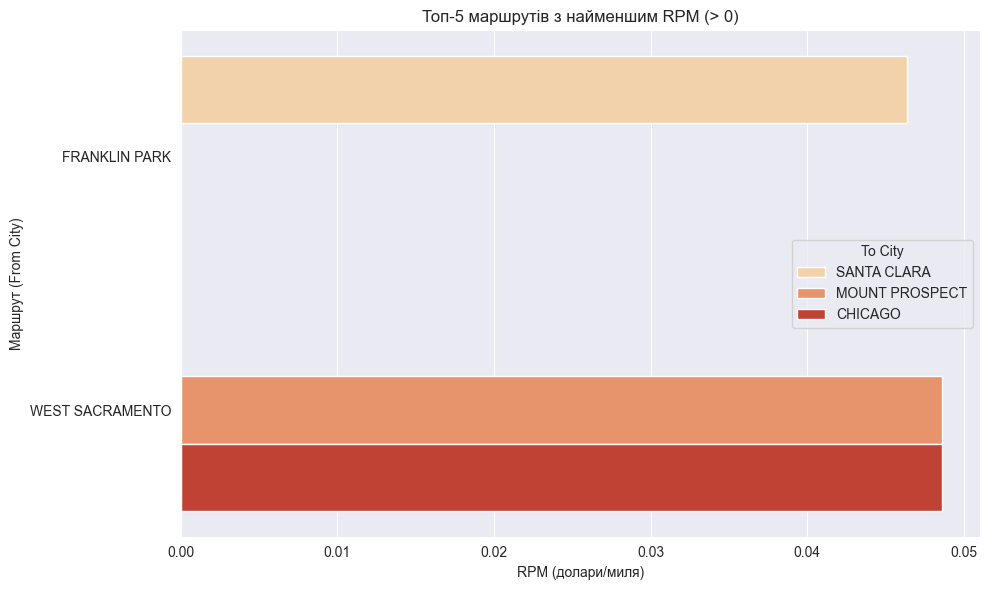

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
top_5_lowest_rpm = df[df["RPM"] > 0].sort_values(by="RPM").head(5)

sns.barplot(
    data=top_5_lowest_rpm,
    y="From City",
    x="RPM",
    hue="To City",
    palette="OrRd"
)
plt.title("Топ-5 маршрутів з найменшим RPM (> 0)")
plt.xlabel("RPM (долари/миля)")
plt.ylabel("Маршрут (From City)")
plt.tight_layout()
plt.show()

# Відображення маршрутів з найменшим RPM на інтерактивній карті

Створюємо карту з використанням Folium. Для кожного з п’яти маршрутів визначаємо координати за допомогою Geopy, прокладаємо маршрут через OpenRouteService і відображаємо лінії та маркери на карті.

In [39]:
from geopy.geocoders import Nominatim
import openrouteservice
from openrouteservice import convert
import folium
import time
from tqdm import tqdm

geolocator = Nominatim(user_agent="logistics-map")
ors_client = openrouteservice.Client(key=ORS_API_KEY)
m_lowest_rpm = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in tqdm(top_5_lowest_rpm.iterrows(), total=top_5_lowest_rpm.shape[0]):
    from_city = row["From City"]
    from_state = row["From State"]
    to_city = row["To City"]
    to_state = row["To State"]
    miles = row["Miles"]
    rate = row["Rate"]
    rpm = row["RPM"]

    try:
        from_loc = geolocator.geocode(f"{from_city}, {from_state}", timeout=10)
        to_loc = geolocator.geocode(f"{to_city}, {to_state}", timeout=10)
        time.sleep(1)

        if from_loc and to_loc:
            from_coords = (from_loc.latitude, from_loc.longitude)
            to_coords = (to_loc.latitude, to_loc.longitude)

            coords = [(from_coords[1], from_coords[0]), (to_coords[1], to_coords[0])]
            route = ors_client.directions(coords)
            decoded = convert.decode_polyline(route['routes'][0]['geometry'])

            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in decoded["coordinates"]],
                tooltip=f"{from_city} → {to_city} | {miles} mi | ${rate} | RPM: {rpm:.2f}",
                color="orange"
            ).add_to(m_lowest_rpm)

            folium.Marker(location=from_coords, popup=f"{from_city}, {from_state}",
                          icon=folium.Icon(color="green")).add_to(m_lowest_rpm)
            folium.Marker(location=to_coords, popup=f"{to_city}, {to_state}",
                          icon=folium.Icon(color="red")).add_to(m_lowest_rpm)
        else:
            print("Пропущено (немає координат):", from_city, "→", to_city)

    except Exception as e:
        print("Помилка маршруту", from_city, "→", to_city, ":", e)

m_lowest_rpm

100%|██████████| 5/5 [00:21<00:00,  4.23s/it]
